## Import required libraries.

In [1]:
%%capture
import operator
import seaborn as sns; sns.set()
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import medfilt
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120) 
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Setup input data 
Define spatial resolution: Specify the resolution of the input DEM and also the desired working resolution (can be same as input DEM resolution).

In [4]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\junk')
os.chdir(location)
input_geotiff = gdal.Open('wean_sub.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

input_outlets = gdal.Open('wean_downstream_5m.tif')
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets= o
#outlets = 1 - o

## Visualise the DEM.

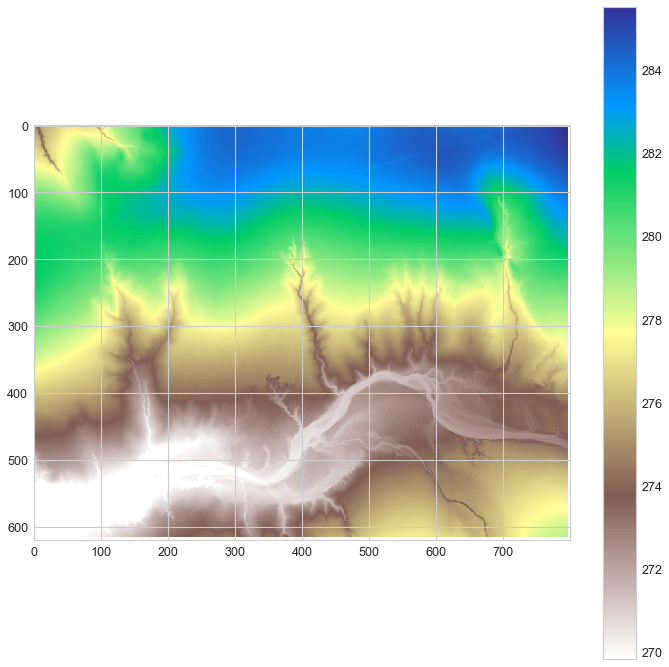

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(input_DEM, cmap="terrain_r", vmin = np.percentile(input_DEM, 5));
plt.colorbar();

## Define required function.

In [64]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def flow_dir_dataset(flow_rec_prop, catchment_area, grid_resolution, outlet_node):
    """ Create an xarray Dataset containing eight arrays each representing the
    amount of water flowing in the given direction.
        1 . flow_rec_prop == the flow receiver proportion array created by LandLab flow routing.
        2 . catchment_area == the corresponding catchment area array from the landLab flow accumulation.
        surface.        
    The resulting Dataset is used to calculate specific catchment area."""
    array_direction = xr.Dataset()
    for i in range(0,8):
        rows = catchment_area.shape[0]; cols = catchment_area.shape[1];
        direction = np.flip(flow_rec_prop[:,i].reshape(rows,cols), 0);
        # Above needs to be flipped because during reshape it organises data top down
        # rather than bottom up as per ModelGrid order (catchment_area is mg arrangement).
        zero_outlet = outlet_node != 1
        remove_outlet = zero_outlet * catchment_area
        weighted_direction = xr.DataArray((remove_outlet * direction),
                                          dims = ['lat', 'lon']);
        array_direction[direction_list[i]] = weighted_direction
        
    E, N, W, S, NE, NW, SW, SE = (array_direction['East'], array_direction['North'],
                             array_direction['West'], array_direction['South'],
                             array_direction['North East'], array_direction['North West'],
                             array_direction['South West'], array_direction['South East'])

    flow_dirs = xr.concat([E, N, W, S, NE, NW, SW, SE], 'direction')
    flow_dirs.name = 'flow_directions'
    flow_dirs.attrs['grid cell resolution'] = grid_resolution
    flow_directions = flow_dirs.assign_coords(direction=(['East','North','West','South',
                                   'North East', 'North West','South West', 'South East']))
    return flow_directions
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def closest(lst, K): 
     angle_list = lst
     idx = (np.abs(angle_list - K)).argmin() 
     return angle_list[idx]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head, min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    upslope_divergence_dict = {}
    slope_dict = {}
    slope_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)
        

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)

        slope_along_central_drainage_line = []
        for key, value in slope_mean_dict.items():
            slope_along_central_drainage_line.append(value)
        slope_mean_above_gully = np.mean(np.array(slope_along_central_drainage_line))
        slope_dict[i] = slope_mean_above_gully
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            upslope_divergence_dict[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHead(dfme_along_central_drainage_line, 
                                                    step_size, comparison_distance, min_depth, gh_elevation)
            upslope_divergence_dict[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, upslope_divergence_dict, slope_dict, slope_at_head
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m

In [7]:
#################################################################################################
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step()

da = np.array(mg.at_node['drainage_area'].round(4));
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node'];
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0);
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

tss = mg.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);

# For all nodes

In [8]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [9]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(outlets, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

61

# For one node

In [10]:
#grid_nodes = np.array(mg.nodes.reshape(mg.shape))
#find_outlet_ids = grid_nodes * outlets
#outlet_id = np.unique(find_outlet_ids)[1]


In [11]:
radius = 9
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
dfme = generic_filter(input_DEM, differenceFromMeanElevation, 
                        footprint= circleWindow(radius), mode='nearest');
dfme[dfme > 5.0] = 5.0
dfme[dfme < -5.0] = -5.0

In [12]:
slope = generic_filter(input_DEM, slopeWindowDegrees,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

In [13]:
shape = 9
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

In [14]:
DFME = generic_filter(input_DEM, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');

In [15]:
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 20

In [16]:
outlet_id = 1841218
outlet_id

1841218

In [65]:
final_gully_heads, divergence_dict, slope_dict, slope_area_data = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area_ha, DFME,gh_list, 3, 3, 10, -0.2, -0.2)

840
(41, 41)
841
842
884
885
886
887
888
930
931
973
1015
10   10
1016
1058
1059
1060
1102
1144
1145
1187
1228
node:  27349.0
minimum downstream value:  -0.520902128559
mean upstream value:  -0.239591897555
std upstream value:  0.0325004167786
minimum downstream value:  -0.231552304958
mean upstream value:  -0.254258468688
std upstream value:  0.0213616515177
minimum downstream value:  -0.237043056563
mean upstream value:  -0.264355082757
std upstream value:  0.0141458306253
minimum downstream value:  -0.237043056563
mean upstream value:  -0.252922369714
std upstream value:  0.00625167184371
minimum downstream value:  -0.237043056563
mean upstream value:  -0.231385362949
std upstream value:  0.0340363241465
minimum downstream value:  -0.231473658867
mean upstream value:  -0.207841513813
std upstream value:  0.0289250829497
minimum downstream value:  -0.282829917938
mean upstream value:  -0.184496410908
std upstream value:  0.00517795671722
minimum downstream value:  -0.282829917938
mea

840
(41, 41)
799
758
716
675
635
594
553
512
470
429
387
10   10
386
426
425
383
341
300
258
218
178
node:  144387.0
minimum downstream value:  -1.00039178298
mean upstream value:  -0.323717763144
std upstream value:  0.0416523279736
minimum downstream value:  -1.15889477636
mean upstream value:  -0.29897431988
std upstream value:  0.044801449532
minimum downstream value:  -1.15889477636
mean upstream value:  -0.312152163942
std upstream value:  0.03850071498
minimum downstream value:  -1.15889477636
mean upstream value:  -0.247670370914
std upstream value:  0.0577004439241
minimum downstream value:  -0.829563186103
mean upstream value:  -0.158093921124
std upstream value:  0.124917752503
minimum downstream value:  -0.622057647102
mean upstream value:  -0.0562888083879
std upstream value:  0.079604396232
840
(41, 41)
799
758
717
676
635
595
555
515
475
434
393
10   10
353
313
314
274
316
275
235
194
153
node:  147303.0
minimum downstream value:  -0.290340498973
mean upstream value:  0.

840
(41, 41)
798
757
716
675
634
593
552
511
470
429
387
10   10
346
304
262
221
180
138
97
56
55
node:  201003.0
minimum downstream value:  -0.504067643358
mean upstream value:  -0.184374340595
std upstream value:  0.0058329703187
840
(41, 41)
799
757
716
674
673
631
590
548
507
465
424
10   10
382
340
299
257
215
174
133
91
132
node:  205732.0
minimum downstream value:  -0.63206753335
mean upstream value:  -0.671614173216
std upstream value:  0.0705893852309
minimum downstream value:  -0.640547198269
mean upstream value:  -0.713003246523
std upstream value:  0.0254949397799
minimum downstream value:  -0.640547198269
mean upstream value:  -0.683024329787
std upstream value:  0.0624719766921
minimum downstream value:  -0.651797811033
mean upstream value:  -0.664580173015
std upstream value:  0.0466671872914
minimum downstream value:  -0.651797811033
mean upstream value:  -0.685909024969
std upstream value:  0.0684544182848
minimum downstream value:  -0.688731438558
mean upstream value:

840
(41, 41)
882
924
966
967
968
928
929
930
931
891
892
10   10
893
894
854
814
815
774
734
694
695
node:  307000.0
minimum downstream value:  -0.499061795563
mean upstream value:  -0.191602905434
std upstream value:  0.0328244403085
840
(41, 41)
799
758
717
675
634
592
550
508
466
424
383
10   10
343
302
261
220
180
139
99
59
60
node:  308964.0
minimum downstream value:  -0.489997833614
mean upstream value:  0.0
std upstream value:  0.0
840
(41, 41)
841
801
761
721
680
639
598
557
516
474
433
10   10
392
351
311
270
230
189
148
107
67
node:  311853.0
minimum downstream value:  -0.360671333645
mean upstream value:  -0.200919330984
std upstream value:  0.0527052212332
minimum downstream value:  -0.360671333645
mean upstream value:  -0.3187444031
std upstream value:  0.120697960278
minimum downstream value:  -0.360671333645
mean upstream value:  -0.336766983052
std upstream value:  0.105949443267
minimum downstream value:  -0.336244243878
mean upstream value:  -0.351471630795
std upstre

215
174
132
node:  378784.0
minimum downstream value:  -0.361349233997
mean upstream value:  -0.248766189193
std upstream value:  0.0142709834935
minimum downstream value:  -0.361349233997
mean upstream value:  -0.235843341812
std upstream value:  0.00400470562085
minimum downstream value:  -0.276331724385
mean upstream value:  -0.186215366771
std upstream value:  0.068259663148
minimum downstream value:  -0.276331724385
mean upstream value:  -0.137794866549
std upstream value:  0.0653425202279
minimum downstream value:  -0.276331724385
mean upstream value:  -0.0610682471154
std upstream value:  0.0432066777483
840
(41, 41)
881
882
883
884
926
927
928
970
1012
1013
1054
10   10
1096
1138
1179
1180
1181
1182
1183
1184
1185
node:  391060.0
minimum downstream value:  -0.596152083205
mean upstream value:  -0.435525283512
std upstream value:  0.00654954273176
minimum downstream value:  -0.485785201604
mean upstream value:  -0.449123337335
std upstream value:  0.0188948351947
minimum downstr

882
924
925
926
927
928
929
930
890
891
933
10   10
974
1014
1055
1097
node:  448619.0
minimum downstream value:  -1.42645372232
mean upstream value:  -1.29565904137
std upstream value:  0.153336443946
minimum downstream value:  -1.42645372232
mean upstream value:  -1.22474218075
std upstream value:  0.126422810737
minimum downstream value:  -1.42242962381
mean upstream value:  -1.19708718361
std upstream value:  0.0921842734813
minimum downstream value:  -1.41431182741
mean upstream value:  -0.951525500955
std upstream value:  0.432206704951
minimum downstream value:  -1.41966157091
mean upstream value:  -0.549221837945
std upstream value:  0.552280794236
minimum downstream value:  -1.41966157091
mean upstream value:  -0.114303005857
std upstream value:  0.161648861103
840
(41, 41)
881
922
963
1004
1044
1085
1125
1166
1207
1248
1289
10   10
1331
1372
1413
1454
1495
1537
1579
1621
1581
node:  461116.0
minimum downstream value:  -1.11648993813
mean upstream value:  -0.951048638667
std u

In [66]:
final_gully_heads

{36941.0: 41745,
 91894.0: 87094,
 97498.0: 87094,
 139587.0: 135584,
 140403.0: 135604,
 144387.0: 135585,
 147303.0: 142504,
 149986.0: 147579,
 155572.0: 150770,
 157208.0: 158014,
 158772.0: 152369,
 159108.0: 159114,
 160108.0: 153707,
 193220.0: 192426,
 199415.0: 194615,
 201003.0: 196202,
 225216.0: 220421,
 238095.0: 233295,
 238895.0: 234095,
 239628.0: 235636,
 273714.0: 273708,
 286930.0: 282132,
 291122.0: 286324,
 297459.0: 297468,
 303562.0: 299566,
 307000.0: 308606,
 308964.0: 304162,
 313188.0: 309192,
 314727.0: 309932,
 346791.0: 337196,
 378784.0: 373177,
 395288.0: 390486,
 420841.0: 416040,
 430675.0: 431481}

In [62]:
len(final_gully_heads)

34

In [18]:
def get_key(val, my_dict):
    gullies_to_keep = []
    for key, value in my_dict.items(): 
         if val == value:
                gullies_to_keep.append(key)
    return gullies_to_keep


In [19]:
gullies_to_keep_node_list = get_key('yes', divergence_dict)

In [20]:
len(gullies_to_keep_node_list)

34

In [21]:
outlet_ids = np.isin(grid_nodes,gullies_to_keep_node_list).astype('uint8')

In [22]:
pd.DataFrame.from_dict(divergence_dict, orient='index')

,0
27349.0,no
28156.0,no
36941.0,yes
91894.0,yes
97498.0,yes
...,...
430675.0,yes
443243.0,no
448619.0,no
461116.0,no


In [26]:
distance_from_outlet = 20
# This value is used to initialise the search.
catchment_outlet_id = 140403
# Initate an outer loop that iterates through every distance interval from the outlet.
watershed_grid_cells = []
node_location = mg.nodes.reshape(da.shape)
ordered_node_list = []

for i in range(0, distance_from_outlet):
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcells = [catchment_outlet_id];
    else:
        candidate_gridcells = list(set(upstream_nodes));
    # Empty the list of upsteam nodes.
    upstream_nodes = {};
    # Intiate a new loop to check every gridcell at the current interval distance.
    print(candidate_gridcells)
    for grid_cell in candidate_gridcells:
        # Check each flow direction of the current grid cell.The second dimension of the 
        # flow__receiver_node object will always be size == 8.
        for i in range(frn.shape[1]):
            # Return all rows (grid nodes) that send any flow to the target grid cell.
            # Note: This can only be one grid cell because the prgram is looping through
            # each direction one at a time so only one grid cell can be sending flow from any
            # one given direction.
            flow_from_whole_grid_cell = frn[np.where(frn[:,i] == grid_cell)];
            # Check if the current direction contributes flow. If not, do nothing. 
            # Else, append to list.
            if flow_from_whole_grid_cell.shape[0] == 0:
                pass
            else:
                # Below variable finds the row position of the flow_from_direction gridcell
                # in the flow__receiver_node array. This corresponds to the contributing
                # cell's node id.
                node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                #Find the proportion of flow leaving the donor node and heading toward 
                # the current grid cell.
                proportion_of_flow = frp[node_id_value, i]
                # Create a boolean array to use as mask on drainage area.
                isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, da))
                node_directional_drainage_area = node_drainage_area * proportion_of_flow
                upstream_nodes.update({node_id_value:node_directional_drainage_area});
        if len(upstream_nodes) == 0:
            print ("dictionary empty")
        else:
            primary_flow_direction_id = max(upstream_nodes.items(), key=operator.itemgetter(1))[0]
            upstream_nodes = []
            upstream_nodes.append(primary_flow_direction_id);
            ordered_node_list.append(primary_flow_direction_id);
            watershed_grid_cells.append(primary_flow_direction_id)
            

preliminary_width = np.isin(node_location,watershed_grid_cells)
flow_width = (preliminary_width * da).reshape(mg.shape)

flow_width[flow_width==0] = np.nan

flow_grid_nodes = (preliminary_width * da).reshape(mg.shape)

drainage_mask = flow_width > 0

drainage_slope = np.copy(slope).astype('float32')
drainage_slope[~drainage_mask] = np.nan

drainage_dfme = np.copy(dfme).astype('float32')
drainage_dfme[~drainage_mask] = np.nan

drainage_area = np.copy(catchment_area_ha).astype('float32')
drainage_area[~drainage_mask] = np.nan

drainage_nodes = np.copy(grid_nodes).astype('float32')
drainage_nodes[~drainage_mask] = np.nan

lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
drainage_dfme_1d = np.squeeze(drainage_dfme.reshape(1, lat * lon))
drainage_slope_1d = np.squeeze(drainage_slope.reshape(1, lat * lon))
drainage_area_1d = np.squeeze(drainage_area.reshape(1, lat * lon))

node_drainage_dfme_dict = {}
for A, B in zip(nodes_1d, drainage_dfme_1d):
    node_drainage_dfme_dict[A] = B

dfme_from_gully_unordered = { key:value for key, value in node_drainage_dfme_dict.items() if ~np.isnan(value)}

# This just reorders the dictionary to reflect the actual node order along the flow line.
# The step above creates a dictionary where the keys are ordered from highest to lowest and this is not always
# going to reflect the node order (only if the flow line is moving south to north).
dfme_from_gully = {k: dfme_from_gully_unordered[k] for k in ordered_node_list}


node_drainage_slope_dict = {}
for A, B in zip(nodes_1d, drainage_slope_1d):
    node_drainage_slope_dict[A] = B

slope_from_gully_unordered = { key:value for key, value in node_drainage_slope_dict.items() if ~np.isnan(value) }
slope_from_gully = {k: slope_from_gully_unordered[k] for k in ordered_node_list}

node_drainage_area_dict = {}
for A, B in zip(nodes_1d, drainage_area_1d):
    node_drainage_area_dict[A] = B

area_from_gully_unordered = { key:value for key, value in node_drainage_area_dict.items() if ~np.isnan(value) }
area_from_gully = {k: area_from_gully_unordered[k] for k in ordered_node_list}


ds = [dfme_from_gully, slope_from_gully, area_from_gully]
d = {}
for k in dfme_from_gully.keys():
    d[k] = tuple(d[k] for d in ds)
d_ordered = {k: d[k] for k in ordered_node_list}

drainage_parameters = pd.DataFrame.from_dict(d_ordered)

drainage_parameters.rename(index={0:'DFME', 1: 'Slope', 2: 'Area'}, inplace=True)

drainage_parameters_transpose = drainage_parameters.T

drainage_parameters_transpose.insert(0, "Distance", 0);

for i in range(0, distance_from_outlet):
    drainage_parameters_transpose.iloc[i,0] = i

drainage_parameters_transpose['Node ID'] = drainage_parameters_transpose.index

dCDFMEdx = np.gradient(drainage_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)

dCSdx = np.gradient(drainage_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(drainage_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)


drainage_parameters_transpose['dCDFMEdx'] = dCDFMEdx

drainage_parameters_transpose['dCSdx'] = dCSdx
drainage_parameters_transpose['dCAdx'] = dCAdx


drainage_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2

drainage_parameters_transpose['d2CSdx2'] = d2CSdx2
drainage_parameters_transpose['d2CAdx2'] = d2CAdx2


cumulative_drainage_parameters = drainage_parameters_transpose.cumsum()
drainage_parameters_transpose['Cumulative DFME'] = cumulative_drainage_parameters.iloc[:,1]

get_median_slope = drainage_parameters_transpose.loc[:,'Slope'].values
get_median_dfme = drainage_parameters_transpose.loc[:,'DFME'].values

median_slope = ndimage.median_filter(get_median_slope, size=3)
median_dfme = ndimage.median_filter(get_median_dfme, size=3)

drainage_parameters_transpose['MedianSlope'] = median_slope
drainage_parameters_transpose['MedianDFME'] = median_dfme

dfme_list = drainage_parameters_transpose.loc[:,'MedianDFME'].values.tolist()


[140403]
[139604]
[138804]
[138004]
[137204]
[136404]
[135604]
[134803]
[134003]
[133203]
[132403]
[131603]
[130804]
[130004]
[129204]
[128403]
[127604]
[126805]
[126005]
[125204]


C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater


In [27]:
drainage_parameters_transpose

,Distance,DFME,Slope,Area,Node ID,dCDFMEdx,dCSdx,dCAdx,d2CDFMEdx2,d2CSdx2,d2CAdx2,Cumulative DFME,MedianSlope,MedianDFME
139604,0,-0.481295,6.940195,0.726907,139604,0.112655,-0.769955,0.018350,-0.046257,0.322542,-0.018561,-0.481295,6.940195,-0.481295
138804,1,-0.368639,6.170240,0.745257,138804,0.066398,-0.447412,-0.000212,-0.039944,0.080587,-0.020060,-0.849934,6.170240,-0.368639
138004,2,-0.348498,6.045370,0.726483,138004,0.032767,-0.608780,-0.021771,-0.005803,-0.009476,-0.042365,-1.198432,6.045370,-0.348498
137204,3,-0.303104,4.952680,0.701715,137204,0.054793,-0.466364,-0.084941,0.027216,0.949867,-0.095545,-1.501536,5.112642,-0.303104
136404,4,-0.238913,5.112642,0.556601,136404,0.087198,1.290953,-0.212861,0.025279,0.182853,-0.045000,-1.740449,5.112642,-0.238913
135604,5,-0.128708,7.534585,0.275994,135604,0.105350,-0.100657,-0.174942,-0.011658,-1.684422,0.078271,-1.869157,5.112642,-0.128708
134803,6,-0.028212,4.911328,0.206717,134803,0.063883,-2.077891,-0.056318,-0.043272,-0.467201,0.066605,-1.897369,4.911328,-0.028212
134003,7,-0.000941,3.378803,0.163357,134003,0.018806,-1.035059,-0.041731,-0.027966,0.694624,0.030297,-1.898310,3.378803,-0.000941
133203,8,0.009400,2.841211,0.123255,133203,0.007952,-0.688644,0.004275,-0.013032,0.188934,0.026043,-1.888910,2.841211,0.009400
132403,9,0.014962,2.001516,0.171907,132403,-0.007258,-0.657192,0.010356,-0.012774,0.198562,-0.012594,-1.873948,2.001516,0.009400


Text(0.5, 1.0, 'Change in upstream values for DFME and PC')

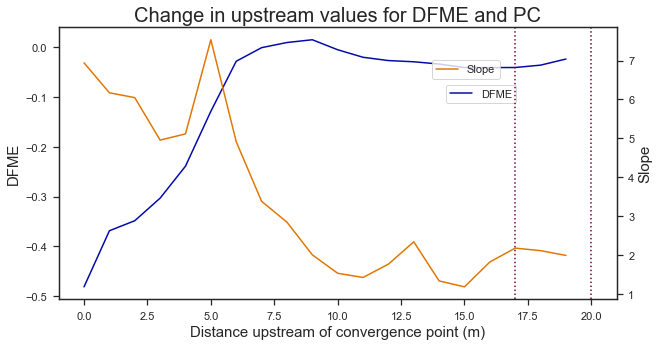

In [29]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
y1 = "DFME"
y2 = "Slope"

sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = y1, color = 'xkcd:cobalt blue')
ax1.set_ylabel(y1, fontsize=15)
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend([y1],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()

#ax2.set_ylim(-0.3,0.3)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y=y2,color='xkcd:pumpkin',ax = ax2)
ax2.set_ylabel(y2, fontsize = 15)
ax2.legend([y2],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
#ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME and PC', fontsize = 20)

In [184]:
algorithm_end_point = drainage_parameters_transpose['Distance'].max()
algorithm_start_point = drainage_parameters_transpose['Distance'].min()

gh = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_end_point,
                                                  'Node ID'].values[0]

cp = drainage_parameters_transpose.loc[drainage_parameters_transpose['Distance'] == algorithm_start_point,
                                                  'Node ID'].values[0]

node_length = np.abs(cp - gh)
length = node_length/mg.shape[0]

In [187]:
gh_lat = np.where(grid_nodes == gh)[0][0]
cp_lat = np.where(grid_nodes == cp)[0][0]
gh_lon = np.where(grid_nodes == gh)[1][0]
cp_lon = np.where(grid_nodes == cp)[1][0]

lat_displacement = cp_lat - gh_lat
lon_displacement = gh_lon - cp_lon

In [189]:
lon_displacement

-12

In [185]:


if lat_displacement > 0 and lon_displacement > 0:
    angle_max = 90
    angle_min = 0
    quadrant = 1
    print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement > 0 and lon_displacement < 0:
    angle_max = 360
    angle_min = 270
    quadrant = 2
    print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
elif lat_displacement < 0 and lon_displacement < 0:
    angle_max = 270
    angle_min = 180
    quadrant = 3
    print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
else:
    angle_max = 180
    angle_min = 90
    quadrant = 4
    print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))

theta_a = np.degrees(np.arctan(np.abs(lat_displacement)/np.abs(lon_displacement)))

if quadrant == 1:
    gully_orientation = angle_max - theta_a
elif quadrant == 2:
    gully_orientation = angle_min + theta_a
elif quadrant == 3:
    gully_orientation = angle_max - theta_a
else:
    gully_orientation = angle_min + theta_a

class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes

gully_and_cross_section = GullyOrientation(gully_orientation, catchment_outlet_id, mg.shape)

line_length = 20

cross_section_nodes = gully_and_cross_section.cross_section(line_length)

cross_section_mask = np.isin(node_location,cross_section_nodes).reshape(mg.shape)
cross_section_image = cross_section_mask.astype('uint8')

cross_section_slope = np.copy(slope).astype('float32')
cross_section_slope[~cross_section_mask] = np.nan

cross_section_dfme = np.copy(dfme).astype('float32')
cross_section_dfme[~cross_section_mask] = np.nan

cross_section_area = np.copy(catchment_area_ha).astype('float32')
cross_section_area[~cross_section_mask] = np.nan

cross_section_nodes = np.copy(grid_nodes).astype('float32')
cross_section_nodes[~cross_section_mask] = np.nan

cross_section_elevation_prep = np.copy(input_DEM).astype('float32')
cross_section_elevation_prep[~cross_section_mask] = np.nan
cross_section_elevation = cross_section_elevation_prep - np.nanmin(cross_section_elevation_prep)

cross_section_dfme_line = cross_section_elevation_prep - np.nanmean(cross_section_elevation_prep)

lat = grid_nodes.shape[0]
lon = grid_nodes.shape[1]
nodes_1d = np.squeeze(grid_nodes.reshape(1, lat * lon))
cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
cross_section_slope_1d = np.squeeze(cross_section_slope.reshape(1, lat * lon))

cross_section_area_1d = np.squeeze(cross_section_area.reshape(1, lat * lon))

cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
cross_section_dfme_line_1d = np.squeeze(cross_section_dfme_line.reshape(1, lat * lon))

node_cross_section_dfme_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_1d):
    node_cross_section_dfme_dict[A] = B

dfme_cross_section_unordered = { key:value for key, value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

node_cross_section_slope_dict = {}
for A, B in zip(nodes_1d, cross_section_slope_1d):
    node_cross_section_slope_dict[A] = B

slope_cross_section_unordered = { key:value for key, value in node_cross_section_slope_dict.items() if ~np.isnan(value)}

node_cross_section_area_dict = {}
for A, B in zip(nodes_1d, cross_section_area_1d):
    node_cross_section_area_dict[A] = B

area_cross_section_unordered = { key:value for key, value in node_cross_section_area_dict.items() if ~np.isnan(value) }

node_cross_section_elevation_dict = {}
for A, B in zip(nodes_1d, cross_section_elevation_1d):
    node_cross_section_elevation_dict[A] = B

elevation_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

node_cross_section_dfme_line_dict = {}
for A, B in zip(nodes_1d, cross_section_dfme_line_1d):
    node_cross_section_dfme_line_dict[A] = B

dfme_line_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_line_dict.items() if ~np.isnan(value) }

ds = [dfme_cross_section_unordered,  
      slope_cross_section_unordered, area_cross_section_unordered, 
     elevation_cross_section_unordered, dfme_line_cross_section_unordered]
d = {}
for k in dfme_cross_section_unordered.keys():
    d[k] = tuple(d[k] for d in ds)

cross_section_parameters = pd.DataFrame.from_dict(d)

cross_section_parameters.rename(index={0:'DFME', 1: 'Slope', 
                                       2: 'Area', 3: 'Elevation', 4: 'DFME Line'}, inplace=True)

cross_section_parameters_transpose = cross_section_parameters.T

cross_section_parameters_transpose.insert(0, "Distance", 0)

for i in range(0, (line_length * 2)+1):
    if i < line_length:
        cross_section_parameters_transpose.iloc[i,0] = -line_length + i
    else:
        cross_section_parameters_transpose.iloc[i,0] = i - line_length

cumulative_cross_section_parameters = cross_section_parameters_transpose.cumsum()

cross_section_parameters_transpose['Cumulative DFME'] = cumulative_cross_section_parameters.iloc[:,1]

cross_section_parameters_transpose['Cumulative S'] = cumulative_cross_section_parameters.iloc[:,3]
cross_section_parameters_transpose['Cumulative A'] = cumulative_cross_section_parameters.iloc[:,4]


extract_slope = cross_section_parameters_transpose['Slope'].values

cross_section_parameters_transpose['Slope Range'] = generic_filter(extract_slope, data_range, 
                                                                       footprint= (1, 3), mode='nearest');

extract_dfme = cross_section_parameters_transpose['DFME'].values

cross_section_parameters_transpose['DFME Range'] = generic_filter(extract_dfme, data_range, 
                                                                       footprint= (1, 3), mode='nearest');


gully_head, distance_upstream = checkGullyHead(dfme_list,3,3, -0.2, -0.1)    

gully_heads_dict.update({catchment_outlet_id:gully_head});


Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
minimum downstream value:  -0.581758618355
mean upstream value:  -0.395161539316
std upstream value:  0.0125836447226
minimum downstream value:  -0.581758618355
mean upstream value:  -0.368167916934
std upstream value:  0.0264297188296
minimum downstream value:  -0.581758618355
mean upstream value:  -0.339391489824
std upstream value:  0.0320271554921
minimum downstream value:  -0.581758618355
mean upstream value:  -0.298925429583
std upstream value:  0.0290891446357
minimum downstream value:  -0.529260218143
mean upstream value:  -0.273739536603
std upstream value:  0.0221515817143
minimum downstream value:  -0.436460703611
mean upstream value:  -0.242708429694
std upstream value:  0.0219276300383
minimum downstream value:  -0.412149429321
mean upstream value:  -0.22642788291
std upstream value:  0.020635497426
minimum downstream value:  -0.391258984804
mean upstream value:  -0.212048356732
std upstream value:  0.0002

NameError: name 'gully_heads_dict' is not defined

In [ ]:
gully_heads_dict

In [ ]:
for name, age in mydict.items():
    if age == search_age:
        print name

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
y1 = "DFME"
y2 = "MedianDFME"

sns.lineplot(data = drainage_parameters_transpose,x = "Distance",y = y1, color = 'xkcd:cobalt blue')
ax1.set_ylabel(y1, fontsize=15)
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance upstream of convergence point (m)', fontsize = 15)
ax1.legend([y1],bbox_to_anchor=(0.3, 0.21, 0.53, 0.6))
ax2 = ax1.twinx()

#ax2.set_ylim(-0.3,0.3)
sns.lineplot(data=drainage_parameters_transpose,x = "Distance",y=y2,color='xkcd:pumpkin',ax = ax2)
ax2.set_ylabel(y2, fontsize = 15)
ax2.legend([y2],bbox_to_anchor=(0.3, 0.5, 0.5, 0.4))
plt.axvline(x=17, color = 'xkcd:merlot', linestyle = 'dotted')
plt.axvline(x=20, color = 'xkcd:merlot', linestyle = 'dotted')
#ax1.text(18, -0.8, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in upstream values for DFME and PC', fontsize = 20)

In [ ]:
gully_head, distance_upstream = checkGullyHead(dfme_list,3,3)    


In [ ]:
gully_head

In [ ]:
dfme_list

In [ ]:
gully_head

In [ ]:
distance_upstream

To find the endpoints of the line at the head of the gully, all i need to do is move n units in the direction of the gully orientation from the end points of the cross section line. Can use same rules from the GullOrientation class.

Note: Method below requires that the outlet_id (A) is at least 10 grid cells from the edge of the DEM. In the paper can just say gullies near edges were not used because it risks moving window values being affected.

## Scheme for finding all grid cells along the desired line.

Four possible line: 

(1) north-south, north direction == outlet_id - mg.shape[1], south direction == outlet_id + mg.shape[1]

(2) east-west, east = outlet_id + 1, west == outlet_id - 1

(3) northeast-southwest, northeast == outlet_id - (mg.shape[1] - 1), southwest == outlet_id + (mg.shape[1] - 1)

(4) northwest-southeast, northwest == outlet_id - (mg.shape[1] + 1), southeast == outlet_id + (mg.shape[1] + 1)


# Calculate the cumulative summary of each variable.

In [ ]:
dCDFMEdx = np.gradient(cross_section_parameters_transpose.loc[:,'DFME'].values)
d2CDFMEdx2 = np.gradient(dCDFMEdx)
 
dCPCdx = np.gradient(cross_section_parameters_transpose.loc[:,'PC'].values)
d2CPCdx2 = np.gradient(dCPCdx)

dCSdx = np.gradient(cross_section_parameters_transpose.loc[:,'Slope'].values)
d2CSdx2 = np.gradient(dCSdx)

dCAdx = np.gradient(cross_section_parameters_transpose.loc[:,'Area'].values)
d2CAdx2 = np.gradient(dCAdx)

dPCTLdx = np.gradient(cross_section_parameters_transpose.loc[:,'PCTL'].values)
d2PCTLdx2 = np.gradient(dPCTLdx)

cross_section_parameters_transpose['dCDFMEdx'] = dCDFMEdx
cross_section_parameters_transpose['dCPCdx'] = dCPCdx
cross_section_parameters_transpose['dCSdx'] = dCSdx
cross_section_parameters_transpose['dCAdx'] = dCAdx
cross_section_parameters_transpose['dPCTLdx'] = dPCTLdx

cross_section_parameters_transpose['d2CDFMEdx2'] = d2CDFMEdx2
cross_section_parameters_transpose['d2CPCdx2'] = d2CPCdx2
cross_section_parameters_transpose['d2CSdx2'] = d2CSdx2
cross_section_parameters_transpose['d2CAdx2'] = d2CAdx2
cross_section_parameters_transpose['d2PCTLdx2'] = d2PCTLdx2

In [ ]:
cross_section_parameters_transpose_spline = pd.DataFrame(np.arange(-100,100)/(100.0/line_length), columns = ['Distance']) 

In [ ]:
spline_smoothness = np.linspace(-line_length,line_length, 200)
spline_input_distance = cross_section_parameters_transpose.loc[:,'Distance'].values

spline_input_dfme = cross_section_parameters_transpose.loc[:,'DFME'].values
dfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
dfme_spline = dfme_spline_setup(spline_smoothness)

spline_input_dfme = cross_section_parameters_transpose.loc[:,'Cumulative DFME'].values
cdfme_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme)
cdfme_spline = cdfme_spline_setup(spline_smoothness)

spline_input_pc = cross_section_parameters_transpose.loc[:,'PC'].values
pc_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_pc)
pc_spline = pc_spline_setup(spline_smoothness)

spline_input_slope = cross_section_parameters_transpose.loc[:,'Slope'].values
slope_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope)
slope_spline = slope_spline_setup(spline_smoothness)

spline_input_slope_range = cross_section_parameters_transpose.loc[:,'Slope Range'].values
slope_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_slope_range)
slope_range_spline = slope_range_spline_setup(spline_smoothness)

spline_input_area = cross_section_parameters_transpose.loc[:,'Area'].values
area_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_area)
area_spline = area_spline_setup(spline_smoothness)

spline_input_dfme_range = cross_section_parameters_transpose.loc[:,'DFME Range'].values
dfme_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_range)
dfme_range_spline = dfme_range_spline_setup(spline_smoothness)

spline_input_dfme_line = cross_section_parameters_transpose.loc[:,'DFME Line'].values
dfme_line_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dfme_line)
dfme_line_spline = dfme_line_spline_setup(spline_smoothness)

spline_input_elevation_range = cross_section_parameters_transpose.loc[:,'Elevation'].values
elevation_range_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_elevation_range)
elevation_range_spline = elevation_range_spline_setup(spline_smoothness)

spline_input_d2CDFMEdx2 = cross_section_parameters_transpose.loc[:,'d2CDFMEdx2'].values
d2CDFMEdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CDFMEdx2)
d2CDFMEdx2_spline = d2CDFMEdx2_spline_setup(spline_smoothness)

spline_input_d2CPCdx2 = cross_section_parameters_transpose.loc[:,'d2CPCdx2'].values
d2CPCdx2_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_d2CPCdx2)
d2CPCdx2_spline = d2CPCdx2_spline_setup(spline_smoothness)

spline_input_dCDFMEdx = cross_section_parameters_transpose.loc[:,'dCDFMEdx'].values
dCDFMEdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCDFMEdx)
dCDFMEdx_spline = dCDFMEdx_spline_setup(spline_smoothness)

spline_input_dCPCdx = cross_section_parameters_transpose.loc[:,'dCPCdx'].values
dCPCdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCPCdx)
dCPCdx_spline = dCPCdx_spline_setup(spline_smoothness)

spline_input_dCSdx = cross_section_parameters_transpose.loc[:,'dCSdx'].values
dCSdx_spline_setup = InterpolatedUnivariateSpline(spline_input_distance, spline_input_dCSdx)
dCSdx_spline = dCSdx_spline_setup(spline_smoothness)

cross_section_parameters_transpose_spline['DFMEL Spline'] = dfme_line_spline
cross_section_parameters_transpose_spline['Elevation Spline'] = elevation_range_spline
cross_section_parameters_transpose_spline['DFMER Spline'] = dfme_range_spline
cross_section_parameters_transpose_spline['DFME Spline'] = dfme_spline
cross_section_parameters_transpose_spline['Cumulative DFME Spline'] = cdfme_spline
cross_section_parameters_transpose_spline['PC Spline'] = pc_spline
cross_section_parameters_transpose_spline['A Spline'] = area_spline
cross_section_parameters_transpose_spline['Slope Spline'] = slope_spline
cross_section_parameters_transpose_spline['SR Spline'] = slope_range_spline
cross_section_parameters_transpose_spline['d2CDFMEdx2 Spline'] = d2CDFMEdx2_spline
cross_section_parameters_transpose_spline['d2CPCdx2 Spline'] = d2CPCdx2_spline
cross_section_parameters_transpose_spline['dCDFMEdx Spline'] = dCDFMEdx_spline
cross_section_parameters_transpose_spline['dCPCdx Spline'] = dCPCdx_spline
cross_section_parameters_transpose_spline['dCSdx Spline'] = dCSdx_spline

# Possible rules
1. Find peak in second derivative of DFME and then the first point it cross the x-axis.
2. Find point that PC goes from large negative to positive and then point that it crosses x-axis.
3. Some combination of 1 & 2. E.g. condition 1 only if first part of condition 2 is also met.

Probably just the first is best but can still talk about considering PC and show graph.

## Can use DFME together with one of slope, pc, area and then use a sum of squares approach to test which of the three models works best on all ~30 gullies.

# Three possible rules:

Just have set maximum distance same as flow line. For edges can be 15m in each direction. The the edge will always just be the maximum DFME or rate of change of DFME (second derivative?).

1. Find peak DFME.

2. Combination DFME and Slope Range. Just look for peak DFME followed by sections of low slope range (<5?) and DFME is within delta of the 0 line.

3. Combined DFME, PC and Slope. Look for DFME peak precded by clear - to + PC change and followed by low slope range (<5?) and DFME is within delta of the 0 line.

Increasing complexity, least squares will see if complexity is needed or not.

Then digitise edges for sample of 30 and do least squares assessment of the three methods.

# Maybe the simplest rule is to find spots where slope is low and DFME is 0.
# Or just find peak in DFME.

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (15, 8))
x_value = "Distance"
y1_value = "DFME Spline"
y2_value = "Slope Spline"
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y1_value, 
             color = 'xkcd:royal purple')
ax1.set_ylabel('Slope (Degrees)', fontsize=20)
#ax1.annotate('Thalweg', arrowprops = dict(facecolor = 'black'), xy = (0, -23), xytext = (1, -29))
#ax1.lines[0].set_linestyle("--")
ax1.set_ylim(-1, 1)
ax1.set_xlabel('Distance from thalwag (m)', fontsize = 20)
ax1.legend([y1_value],bbox_to_anchor=(0.375, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-45, 45)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = x_value, y = y2_value
             , color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
#ax2.set_ylabel(y2_value, fontsize = 15)
ax2.set_ylabel('DFME (m)', fontsize = 20)
ax2.legend([y2_value],bbox_to_anchor=(0.375, 0.55, 0.5, 0.4))
plt.axvline(x=11, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-12, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
plt.axhline(y=0, color = 'xkcd:cobalt blue', linewidth = 1, alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=11, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-12.5, -0.5, r'Left Edge', fontsize=15, rotation = 90)
ax1.text(10.5, -0.5, r'Right Edge', fontsize=15, rotation = 90)
plt.title('Gully cross section DFME and slope', fontsize = 25)

# 

## Second derivative works best because the highest rate is the middle of the wall going up and the point that then crosses the x-axis when the increase stops being positive (immediately after passing up over the edge of the gully) - straight from graph theory. 

## First derivative.

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
#ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
#ax2.set_ylim(-0.2, 0.2)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green', ax = ax2)
ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=7, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(11.5, -0.075, r'Gully head', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

In [ ]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "S Spline", 
             color = 'xkcd:forest green')
ax1.set_ylabel('DFME (m)', fontsize=15)
#ax1.annotate('Transition', arrowprops = dict(facecolor = 'black'), xy = (15.5, 0), xytext = (7, 0.06))
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(-0.4, 0.4)
ax1.set_xlabel('Distance downstream (m)', fontsize = 15)
ax1.legend(['DFME'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax2 = ax1.twinx()
ax2.set_ylim(-0.6, 0.6)
sns.lineplot(data = cross_section_parameters_transpose_spline, x = "Distance", y = "d2CDFMEdx2 Spline", 
             color = 'xkcd:royal purple', ax = ax2)
#ax2.lines[0].set_linestyle("--")
ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['PC'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
plt.axvline(x=3, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axvline(x=-4, color = 'xkcd:apricot', linewidth = 14, alpha = 0.5)
plt.axhline(y=0, color = 'xkcd:cobalt blue', alpha = 0.5, linestyle = 'dotted')
#plt.axvline(x=6.5, color = 'xkcd:pumpkin', linestyle = 'dotted')
ax1.text(-4.5, 35, r'L. edge', fontsize=15, rotation = 90)
ax1.text(2.5, 35, r'R. edge', fontsize=15, rotation = 90)
plt.title('Second derivative of DFME and PC cumulative upstream sum', fontsize = 20)

In [ ]:
# Extract the data we're interested in
dfme, dist = cross_section_parameters_transpose['DFME'], cross_section_parameters_transpose['Distance']
pc, slope = cross_section_parameters_transpose['PC'], cross_section_parameters_transpose['Slope']

# Scatter the points, using size and color but no label
plt.scatter(dist, dfme, label=None,
            c=pc, cmap='viridis',
            s=slope, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('Distance')
plt.ylabel('Difference from mean elevation')
plt.colorbar(label='slope')
plt.clim(-0.1, 0.1)

# Here we create a legend:

# we'll plot empty lists with the desired size and label
for slope in [1, 2, 5]:
    plt.scatter([], [], c='k', alpha=0.3, s=slope,
                label=str(slope) + ' ha')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Gully plot')

plt.title('California Cities: Area and Population');

In [ ]:
cross_section_parameters_transpose_spline.head()

In [ ]:
cross_section_parameters_transpose['PC'].nunique()

In [ ]:
sns.set(style="white")

f = sns.relplot(x="Distance", y="DFME", hue="PC", size="Slope",
            sizes=(20, 200), alpha=.5, height=6, data=cross_section_parameters_transpose)

plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
f.set(ylim = (-0.5, 0.5))

## Organise one field of the dataframe into categories so that I can use the palettes in below plot. n_colors below refers to the number of categories assigned to 'name'.

In [ ]:
bins = [-0.2, -0.1, -0.05, -0.01, 0, 0.01, 0.05, 0.1, 0.2]
names = ['- 0.2','- 0.1', '- 0.05', '- 0.01', '0.01', '0.05','0.1', '0.2']

cross_section_parameters_transpose['Profile Curvature'] = pd.cut(cross_section_parameters_transpose['PC'], 
                                                                 bins, labels=names)

In [ ]:
filtered_pc = np.copy(cross_section_parameters_transpose['PC'].values)
filtered_pc[filtered_pc < 0] = np.nan
cross_section_parameters_transpose['PC Filtered'] = filtered_pc

In [ ]:
filtered_dfme = np.copy(cross_section_parameters_transpose['DFME'].values)
filtered_dfme[filtered_dfme < 0.05] = np.nan
cross_section_parameters_transpose['DFME Filtered'] = filtered_dfme

In [ ]:
filtered_slope = np.copy(cross_section_parameters_transpose['Slope'].values)
filtered_slope[filtered_slope < 10] = np.nan
cross_section_parameters_transpose['Slope Filtered'] = filtered_slope

### Three simple models are:

1. Just DFME peak near thalweg.
2. DFME peak plus positive PC.
3. DFME peak, positive PC and low slope range.

In [ ]:
# Load the example planets dataset
#palette = sns.diverging_palette(10, 220, sep=1, n=8)
palette = sns.color_palette('RdBu')
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize =(12,9))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
f = sns.scatterplot(x="Distance", y="DFME Filtered",
                     hue="PC", size="Slope",
                     palette=cmap, sizes=(20, 200),
                     data=cross_section_parameters_transpose)
f.set(ylim = (-1, 1))
f.set(xlim = (-30, 30))
plt.axhline(y=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:merlot', alpha = 0.2, linestyle = '--')

In [ ]:
cross_section_parameters_transpose.drop(columns=['PC Filtered', 'DFME Filtered', 'Slope Filtered']);

In [ ]:
#sns.set(style="whitegrid")
sns.set(style = 'ticks')
#palette = sns.color_palette("RdBu", n_colors = 6)
palette = sns.diverging_palette(10, 220, sep=1, n=8)
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Distance", y="DFME", hue="Profile Curvature", size="Slope", palette = palette, sizes = (20, 200),
             alpha=.8, height=6, data=cross_section_parameters_transpose)
#f.set(ylim = (-0.3, 0.3))
plt.axhline(y=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')
plt.axvline(x=0, color = 'xkcd:black', alpha = 0.2, linestyle = '--')


In [23]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [25]:
np_array_to_Geotiff('wean_final_gullies.tif', input_geotiff, outlet_ids, drainage_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
